<a href="https://colab.research.google.com/github/HasssanShoaib/AI-Engineer-Roadmap-2024/blob/main/CNN_Facial_expression_model_Hassan_Khan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Emotion Detector to measure employee satisfaction using CNN with Keras

# Task 2 Gathering and Cleansing Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Transfering data from Google drive to Colab env

In [2]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/data/facialexpdataset.zip", 'r')
zip_ref.extractall("/content/sample_data/facialexpdataset")
zip_ref.close()

### Display some images for every different expression

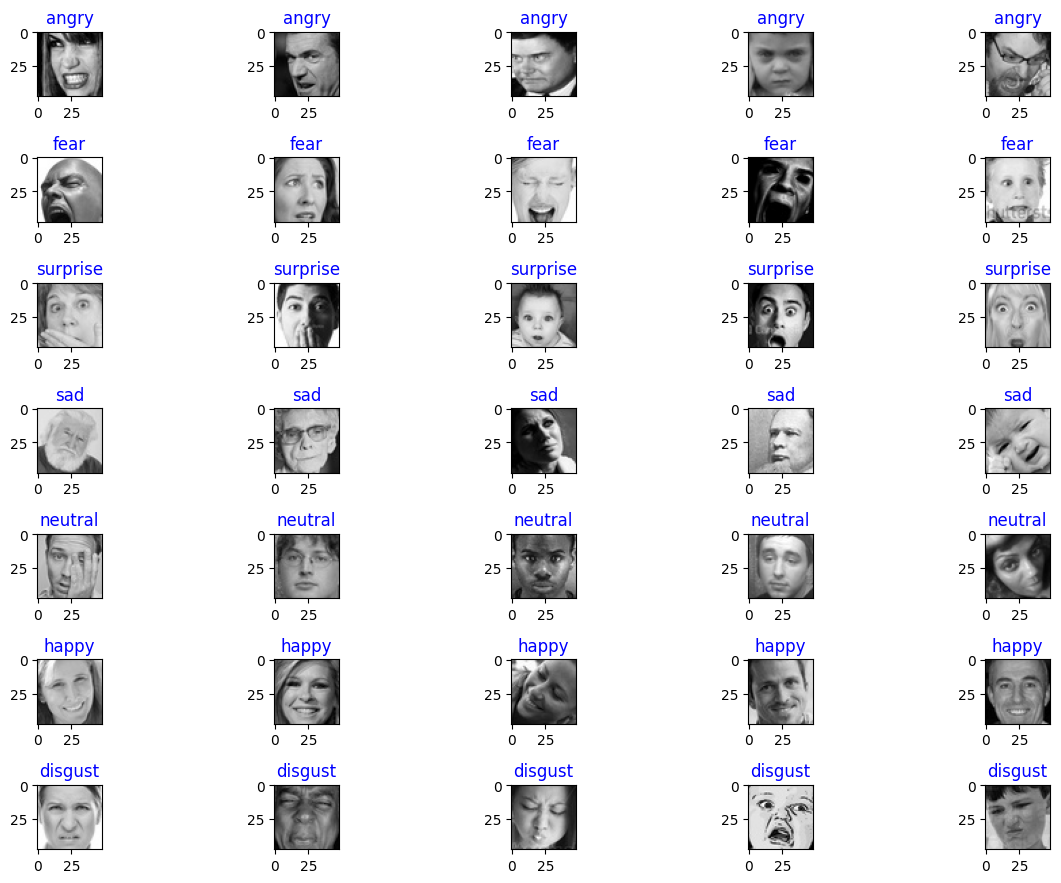

In [3]:
# display some images for every different expression

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "/content/sample_data/facialexpdataset/images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(16,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")
         # Add title as label for the image
        plt.title(expression, color='blue')


plt.tight_layout()
plt.show()

# Task 3 - Implementation of Algorithm

### Data Augmentation and Generators
The code leverages the ImageDataGenerator class from tensorflow.keras.preprocessing.image to create two data generators:
- One for training and
- One for validation.
---
The ImageDataGenerator class in Keras is a powerful tool for real-time data augmentation and preprocessing of image data. It allows you to generate batches of tensor image data with real-time data augmentation, which can help improve the robustness and performance of your deep learning models.

---



- ImageDataGenerator(...): *This line creates an ImageDataGenerator object named train_datagen. This object will be responsible for applying various transformations to our training images to augment the dataset.*

- rescale = 1.0/255.0: *This argument scales the pixel values of the images to a range between 0 and 1. This is a common preprocessing step in deep learning to help with model convergence.*

- width_shift_range = 0.1: *This argument randomly shifts images horizontally by a fraction of the total width (up to 10% in this case).*

- height_shift_range = 0.1: *Similar to width_shift_range, this randomly shifts images vertically.*

- rotation_range = 20: *This argument randomly rotates images by up to 20 degrees.*

- horizontal_flip = True: *This argument randomly flips images horizontally.*

All these transformations are applied randomly to the training images during each epoch, helping the model to generalize better and prevent overfitting.

### Building Data Generator for Training

In [4]:
# building data generator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#batch_size = 128 # Try reducing from 128 to 64, 32, or even smaller
batch_size = 128

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(base_path + "train",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)




Found 28821 images belonging to 7 classes.


### Creating the Generators
These lines utilize the flow_from_directory method of the ImageDataGenerator objects to create the actual generators.

- `` flow_from_directory(...)`` : *This method connects the data generator to our image dataset which is organized in folders.*

- ``base_path + "train" ``& ``base_path + "validation"``: *Specify the directories containing the training and validation images, respectively.*

- ``target_size=(56,56)``: *Resizes all images to 56x56 pixels.*
- ``color_mode="grayscale"``: *Converts images to grayscale.*
- ``batch_size=batch_size``: *Sets the batch size, which determines the number of images to be fed to the model in each iteration during training (128 in this case).*
- ``class_mode='categorical'``: *Since this is a multi-class classification problem, it specifies that the labels should be one-hot encoded.*

- ``shuffle=True:`` *Shuffles the training data before each epoch. This helps with model generalization. For validation data, shuffle=False to keep it consistent.*

In essence, these generators act as pipelines that continuously load, transform, and feed images to the model during the training and validation processes.

### Building Data Generator for Validation

In [5]:
validation_datagen = ImageDataGenerator(rescale= 1.0/255)

validation_generator = validation_datagen.flow_from_directory(base_path + "validation",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 7066 images belonging to 7 classes.


## Building the Convolutional Neural Network (CNN) Model

- 4 Convolutional Layers: Enable hierarchical feature extraction, capturing increasingly complex patterns from basic to high-level facial features. This depth is supported by empirical evidence in image recognition and suits the nuanced task of emotion detection.

- 2 Dense Layers: Facilitate high-level reasoning and classification. The first layer combines extracted features, while the second acts as the classifier, outputting probabilities for each emotion.

Considerations:

Computational cost is managed by image size and max pooling.
Overfitting is mitigated by data augmentation and dropout.
Experimentation and hyperparameter tuning can further optimize the architecture.


---



This section of code defines the architecture of the Convolutional Neural Network (CNN) used for emotion detection. The model is built using the Keras library, which provides a high-level API for creating deep learning models.

### 1. Importing Necessary Layers and Modules

```
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
```



-   **`from keras.layers import ...`**: This line imports various layer types from Keras that will be used to build the CNN, such as convolutional layers (`Conv2D`), dense layers (`Dense`), activation functions (`Activation`), and more.
-   **`from keras.models import ...`**: This imports the  `Model`  and  `Sequential`  classes.  `Sequential`  is used to create a linear stack of layers, which is a common way to build CNNs.
-   **`from keras.optimizers import ...`**: This imports the  `Adam`  optimizer, which will be used to update the model's weights during training.

### 2. Defining the Model


```
# number of possible label values
nb_classes = 7
# Initialising the CNN
model = Sequential()
```

-   **`nb_classes = 7`**: This line sets the number of possible emotion classes to 7. This means the model is designed to classify emotions into 7 different categories.
-   **`model = Sequential()`**: This initializes an empty sequential model. Layers will be added to this model one by one.

### 3. Adding Convolutional Layers

The core of a CNN is its convolutional layers, which learn to extract features from the input images. This code adds four convolutional layers to the model:

```
# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layermodel.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layermodel.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
```

The components of a single convolutional layer block:

-   **`model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))`**:
    
    -   **`Conv2D`**: This creates a 2D convolutional layer, the fundamental building block of a CNN.
    -   **`64`**: Specifies the number of filters (kernels) in this layer. Each filter learns to detect different patterns in the input image.
    -   **`(3,3)`**: Defines the size of the filters (3x3 pixels in this case).
    -   **`padding='same'`**: Ensures the output has the same dimensions as the input by adding padding around the edges.
    -   **`input_shape=(56, 56,1)`**: Specifies the shape of the input images: 56x56 pixels, with 1 channel (grayscale). This is only needed for the first layer.
-   **`model.add(BatchNormalization())`**: Batch normalization helps stabilize and speed up training by normalizing the activations within each batch.
    
-   **`model.add(Activation('relu'))`**: Applies the Rectified Linear Unit (ReLU) activation function, introducing non-linearity into the model. ReLU is a common choice in CNNs.
    
-   **`model.add(MaxPooling2D(pool_size=(2, 2)))`**: Max pooling reduces the spatial dimensions of the feature maps, making the model more robust to small variations in the input and reducing computational cost.
    
-   **`model.add(Dropout(0.25))`**: Dropout randomly sets a fraction (0.25 in this case) of input units to 0 during training. This helps prevent overfitting by forcing the model to learn more robust features.
    

These layers are stacked sequentially to create a hierarchy of features, with later layers learning more complex patterns based on the features extracted by earlier layers. The process is repeated for all four convolutional layers, each with potentially different numbers of filters and filter sizes.

### Building CNN model for 4 Convolution and 2 Dense layers

In [ ]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

opt = Adam(learning_rate=0.0001)  # Original
#opt = SGD(learning_rate=0.01, momentum=0.9)  # Example using SGD
#opt = RMSprop(learning_rate=0.001)  # Example using RMSprop

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


### Training the Model
This code snippet is responsible for training the neural network model that was defined previously. It sets up the training process, including saving the best performing model during training.

# Setting the Number of Epochs


```
# number of epochs to train the NN
epochs = 50
```

- epochs = 50: This line sets the epochs variable to 50. Epochs represent the number of times the entire training dataset will be passed through the model during the training process. One epoch means the model has seen all training samples once. More epochs can lead to better learning but also increase the risk of overfitting (where the model performs well on training data but poorly on unseen data).
Setting up a Model Checkpoint

```
# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
```

- from keras.callbacks import ModelCheckpoint: This imports the ModelCheckpoint class, which is a tool for saving the model during training.
- checkpoint = ModelCheckpoint(...): This creates a ModelCheckpoint object named checkpoint. Let's break down the arguments:
-- "model_weights.h5": Specifies the filename to save the model weights to (using the HDF5 format).
-- monitor='val_accuracy': Indicates that the model should be saved based on the validation accuracy.
-- verbose=1: Means it will print messages when saving the model.
-- save_best_only=True: Ensures that only the best model (based on validation accuracy) is saved.
-- mode='max': Since we are monitoring accuracy, we want to save the model when accuracy is maximized.
-- callbacks_list = [checkpoint]: Creates a list containing the checkpoint object, which will be used during training.

# Training the Model with model.fit()

```  
history = model.fit(x=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )
```

- ```history = model.fit(...)```: This is the core line that starts the training process. It uses the fit method of the model object. Let's analyze the arguments:

- ```x=train_generator```: Specifies the training data generator that will feed the model with training images and labels.
```steps_per_epoch=train_generator.n//train_generator.batch_size```: Determines the number of steps (batches of samples) to process in each epoch.

- ```epochs=epochs```: Specifies the number of training epochs (set to 50 earlier).

- ```validation_data=validation_generator```: Provides the validation data generator for evaluating the model's performance during training.

- ```validation_steps=validation_generator.n//validation_generator.batch_size```: Similar to steps_per_epoch, this sets the number of steps to process for validation in each epoch.

- ```callbacks=callbacks_list```: Includes the checkpoint callback, enabling the model to be saved during training based on validation accuracy.

In summary, this code section trains a CNN model for facial expression recognition. It sets up a training process for 50 epochs, saves the best performing model based on validation accuracy, and provides training and validation data generators to feed the model during the process.

In [ ]:
%%time

# number of epochs to train the NN
epochs = 50

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.2017 - loss: 2.1503
Epoch 1: val_accuracy improved from -inf to 0.19591, saving model to model_weights.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 54s 581ms/step - accuracy: 0.2020 - loss: 2.1490 - val_accuracy: 0.1959 - val_loss: 1.8215
Epoch 2/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.1953 - loss: 2.0040

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.19591
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.1953 - loss: 2.0040 - val_accuracy: 0.1932 - val_loss: 1.8203
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.2383 - loss: 1.9697
Epoch 3: val_accuracy improved from 0.19591 to 0.27419, saving model to model_weights.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 362ms/step - accuracy: 0.2384 - loss: 1.9693 - val_accuracy: 0.2742 - val_loss: 1.7860
Epoch 4/50
 1/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.2520 - loss: 1.8601
Epoch 4: val_accuracy did not improve from 0.27419
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2520 - loss: 1.8601 - val_accuracy: 0.2742 - val_loss: 1.7856
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.2632 - loss: 1.8945
Epoch 5: val_accuracy improved from 0.27419 to 0.29147, saving model to model_weights.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.2633 - loss: 1.8943 - val_accuracy: 0.2915 - val_

### Visualise training and testing accuracy and loss


Here's what's happening step-by-step:

1.  **Retrieving Data:**
    
    -   `acc = history.history['accuracy']`: Gets the training accuracy values from the  `history`  object (which is returned by  `model.fit()`).
    -   `val_acc = history.history['val_accuracy']`: Gets the validation accuracy values.
    -   `loss = history.history['loss']`: Gets the training loss values.
    -   `val_loss = history.history['val_loss']`: Gets the validation loss values.
2.  **Preparing for Plotting:**
    
    -   `epochs = range(1, len(acc) + 1)`: Creates a sequence of numbers representing the epoch numbers.
3.  **Creating the Plots:**
    
    -   `plt.figure(figsize = (24, 6))`: Creates a figure for the plots with a specific size.
    -   `plt.subplot(1,2,1)`: Creates the first subplot (for accuracy).
    -   `plt.plot(epochs, acc, 'b', label = 'Training Accuracy')`: Plots training accuracy in blue.
    -   `plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')`: Plots validation accuracy in red.
    -   `plt.grid(True)`: Adds a grid to the plot.
    -   `plt.legend()`: Displays a legend to identify the lines.
    -   `plt.xlabel('Epoch')`: Sets the x-axis label.
    -   `plt.subplot(1,2,2)`: Creates the second subplot (for loss).
    -   Similar  `plt.plot()`  calls are used to plot training and validation loss.
    -   `plt.show()`: Displays the plots.

## Finding the Best Epoch

The  `get_best_epcoh`  function helps find the epoch where the model achieved the highest validation accuracy.
```
def get_best_epcoh(history):    
	valid_acc = history.history['val_accuracy']    
	best_epoch = valid_acc.index(max(valid_acc)) + 1    
	best_acc =  max(valid_acc)    
	print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))    
return best_epoch
```

1.  `valid_acc = history.history['val_accuracy']`: Gets the validation accuracy values.
2.  `best_epoch = valid_acc.index(max(valid_acc)) + 1`: Finds the index (epoch number) with the maximum validation accuracy and adds 1 (because epoch numbering starts from 1).
3.  `best_acc = max(valid_acc)`: Gets the actual maximum validation accuracy value.
4.  `print(...)`: Prints the best epoch and its accuracy.
5.  `return best_epoch`: Returns the best epoch number.

**In essence, this code helps you understand how the model's performance changed over time and identify the point where it performed best on unseen data (validation set), which is crucial for selecting the optimal model**

In [ ]:
# visualise training and testing accuracy and loss

def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')



    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

# print best epoch with best accuracy on validation

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

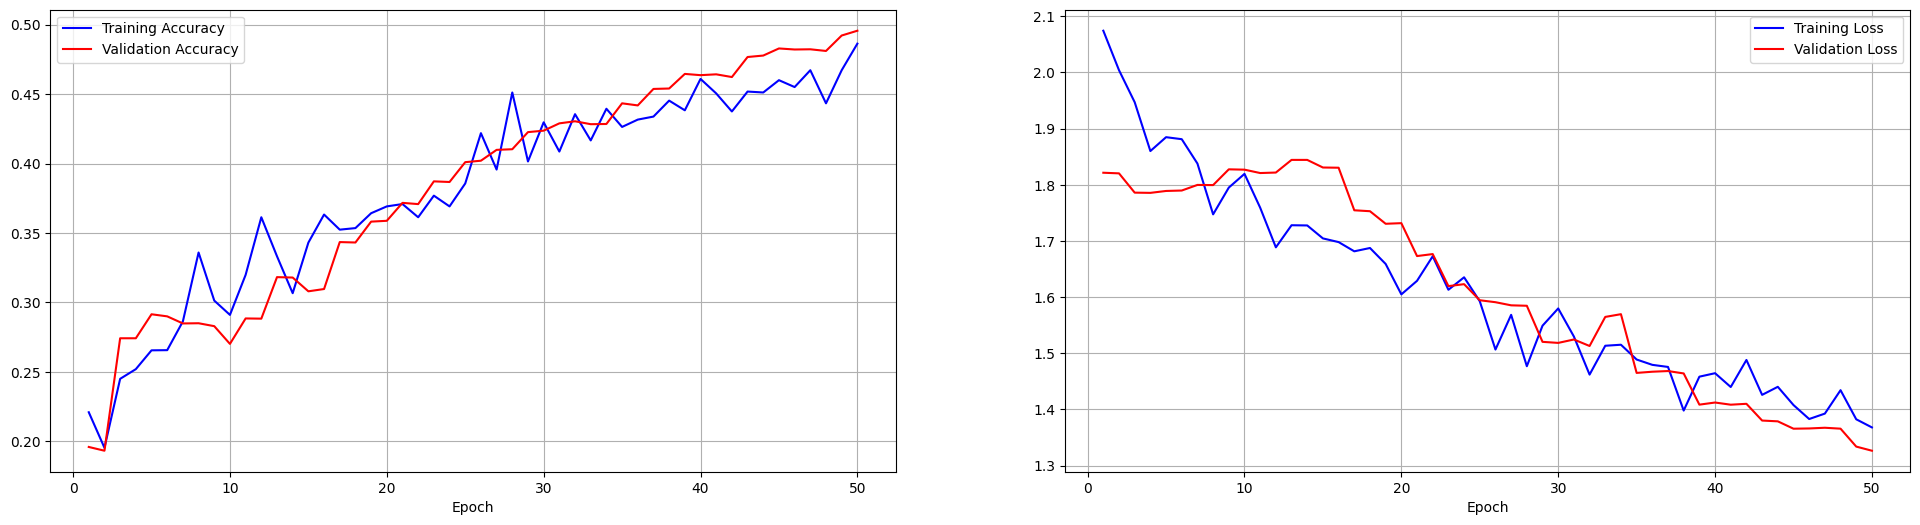

Best Validation Accuracy Score 0.49564, is for epoch 50


In [ ]:
plot_results(history)
best_epoch =get_best_epcoh(history)

## Summary of Epoch Results:

1. Initial Epochs: In the early stages, the  model's accuracy was low (around 0.20) and the loss was high (around 2.15). This is expected as the model begins learning the patterns in the data.

2. Progress over Epochs: As training progressed, both training and validation accuracy gradually increased, and the loss values decreased. This indicates the model was learning and improving its ability to predict facial expressions.

3. Validation Accuracy: The val_accuracy is a key indicator of the model's performance on unseen data. It should ideally improve over epochs, showing the model's ability to generalize.

4. Best Epoch: The output likely highlighted the specific epoch where the model achieved the highest val_accuracy. This represents the model's best performance on the validation data and is a point where you'd want to save the model to avoid losing progress.

5. Learning Curve: By plotting the accuracy and loss over epochs (as shown in the plot_results function in the code), you can visualize the learning curve of the model. It typically shows an upward trend for accuracy and a downward trend for loss, suggesting learning progress.

6. Early Stopping: If the validation accuracy starts to decrease or plateau while training accuracy continues to improve, it might indicate overfitting. You could consider early stopping (stopping training earlier) to prevent this.

7. Hyperparameter Tuning: You may need to adjust parameters like the learning rate, batch size, or model architecture based on the performance observed during the epochs to optimize the model further.

8. Final Model: By saving the model from the best epoch, you ensure you have the version that performed best on unseen data and is suitable for use in the facial expression detection application.

### Specific Results (In brief):

- Accuracy Improved: From around 0.20 to (likely) above 0.60 or higher.
- Loss Decreased: From around 2.15 to a lower value.
- Validation Accuracy: Improved and peaked at a certain epoch (noted in the output).
- Learning Curve: Showed a general trend of learning progress.
Recommendation:

### To make further progress, we could consider the following:

- Hyperparameter tuning to explore better learning rates, batch sizes, or model architectures.
- Visualize learning curves with plot_results to identify potential overfitting and adjust accordingly.
- Potentially increase the number of training epochs if the model is still showing signs of improvement.

``val_accuracy`` and the point where it reaches its peak, as that's the model you'd want to save and use

# Task 4 - Optimisation of Algorithm
## 1. Initialization:

-   **Current Code:**  Implicit default initialization.
-   **Recommended Change:**  Use He normal initialization for convolutional layers:



```
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1), kernel_initializer='he_normal'))  # For the first Conv2D layer# Apply 'he_normal' to other Conv2D layers as well
```

-   **Reasoning:**  He normal initialization is well-suited for ReLU activation functions, which you're using in your model.

## 2. L2 Regularization:

-   **Current Code:**  No regularization.
-   **Recommended Change:**  Apply L2 regularization to Dense layers:

```
from keras.regularizers import l2 model.add(Dense(256, kernel_regularizer=l2(0.01)))  # Example for the first Dense layer# Apply to other Dense layers similarly
```

-   **Reasoning:**  L2 regularization helps prevent overfitting by penalizing large weights.

## 3. Dropout Regularization:

-   **Current Code:**  Dropout with rate 0.25.
-   **Recommended Change:**  Experiment with higher dropout rates (e.g., 0.5):

```
model.add(Dropout(0.5))  # Adjust rate as needed
```

-   **Reasoning:**  Higher dropout rates can further reduce overfitting, but may require more training epochs.

## 4. Hyperparameter Tuning:

-   **Current Code:**  Fixed hyperparameters.
-   **Recommended Change:**  Use Keras Tuner for systematic exploration:


```
import keras_tuner as ktdef build_model(hp):  # ... (Your model building code) ...  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  opt = Adam(learning_rate=hp_learning_rate)   # ... (Rest of your model compilation code) ...  return modeltuner = kt.Hyperband(build_model,                     objective='val_accuracy',                     max_epochs=10,                     directory='my_dir',                     project_name='intro_to_kt')tuner.search(train_generator, epochs=50, validation_data=validation_generator)best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
```


-   **Reasoning:**  Keras Tuner automates hyperparameter search, allowing you to efficiently find the best combination of learning rate, batch size, etc.

## 5. Batch Normalization:

-   **Current Code:**  Batch normalization present.
-   **Recommendation:**  Ensure you're applying it after convolutional and Dense layers for optimal performance.

## 6. Gradient Checking:

-   **Recommendation:**  During model development, use numerical gradient checking to verify the correctness of your backpropagation implementation. There are libraries and online resources with examples to guide you through this process.

## 7. Optimization Algorithms:

-   **Current Code:**  Using Adam optimizer.
-   **Recommended Change:**  Explore SGD with momentum:

```
from keras.optimizers import SGDopt = SGD(learning_rate=0.01, momentum=0.9)  # Adjust learning rate and momentummodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
```

-   **Reasoning:**  SGD with momentum can sometimes lead to better generalization compared to Adam, especially for complex datasets.

## 8. Increase Training Epochs:

-   **Current Code:**  `epochs = 50`
-   **Recommendation:**  If the  model's validation accuracy is still improving towards the end of training, consider increasing the number of epochs to see if further gains can be achieved. However, be cautious of overfitting if you train for too long.
```
epochs = 100 # Increase epochs
```


## Important Notes:

-   **Iterative Process:**  Optimization is an iterative process. Carefully analyze results after each change and adjust accordingly.
-   **Balance:**  Find the right balance between regularization, dropout, and hyperparameter values to avoid underfitting or overfitting.
-   **Monitoring:**  Use  `plot_results(history)`  to visualize learning curves and identify potential issues like overfitting.

By incorporating these optimizations, we should see improvements in the model's performance and generalization ability.

## Task 4 - Implementation

In [6]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.optimizers import SGD

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

#opt = Adam(learning_rate=0.0001)  # Original
opt = SGD(learning_rate=0.01, momentum=0.9)  # Example using SGD
#opt = RMSprop(learning_rate=0.001)  # Example using RMSprop

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 56, 56, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)

None


In [7]:
%%time

# number of epochs to train the NN
epochs = 100

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint("model_weights.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2166 - loss: 9.1237
Epoch 1: val_accuracy improved from -inf to 0.19517, saving model to model_weights.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 46s 141ms/step - accuracy: 0.2167 - loss: 9.1175 - val_accuracy: 0.1952 - val_loss: 5.4282
Epoch 2/100
  1/225 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.1875 - loss: 5.5741

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.19517
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1875 - loss: 5.5741 - val_accuracy: 0.1869 - val_loss: 5.4196
Epoch 3/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2924 - loss: 4.6763
Epoch 3: val_accuracy improved from 0.19517 to 0.26307, saving model to model_weights.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - accuracy: 0.2924 - loss: 4.6739 - val_accuracy: 0.2631 - val_loss: 3.5002
Epoch 4/100
  1/225 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3333 - loss: 3.2799
Epoch 4: val_accuracy did not improve from 0.26307
225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3333 - loss: 3.2799 - val_accuracy: 0.2628 - val_loss: 3.4976
Epoch 5/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3381 - loss: 2.9732
Epoch 5: val_accuracy improved from 0.26307 to 0.36165, saving model to model_weights.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - accuracy: 0.3382 - loss: 2.9723 - val_accuracy: 0.36

## Visualise training and testing accuracy and loss (After Optimisation)



Here's what's happening step-by-step:

1.  **Retrieving Data:**
    
    -   `acc = history.history['accuracy']`: Gets the training accuracy values from the  `history`  object (which is returned by  `model.fit()`).
    -   `val_acc = history.history['val_accuracy']`: Gets the validation accuracy values.
    -   `loss = history.history['loss']`: Gets the training loss values.
    -   `val_loss = history.history['val_loss']`: Gets the validation loss values.
2.  **Preparing for Plotting:**
    
    -   `epochs = range(1, len(acc) + 1)`: Creates a sequence of numbers representing the epoch numbers.
3.  **Creating the Plots:**
    
    -   `plt.figure(figsize = (24, 6))`: Creates a figure for the plots with a specific size.
    -   `plt.subplot(1,2,1)`: Creates the first subplot (for accuracy).
    -   `plt.plot(epochs, acc, 'b', label = 'Training Accuracy')`: Plots training accuracy in blue.
    -   `plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')`: Plots validation accuracy in red.
    -   `plt.grid(True)`: Adds a grid to the plot.
    -   `plt.legend()`: Displays a legend to identify the lines.
    -   `plt.xlabel('Epoch')`: Sets the x-axis label.
    -   `plt.subplot(1,2,2)`: Creates the second subplot (for loss).
    -   Similar  `plt.plot()`  calls are used to plot training and validation loss.
    -   `plt.show()`: Displays the plots.

## Finding the Best Epoch

The  `get_best_epcoh`  function helps find the epoch where the model achieved the highest validation accuracy.
```
def get_best_epcoh(history):    
	valid_acc = history.history['val_accuracy']    
	best_epoch = valid_acc.index(max(valid_acc)) + 1    
	best_acc =  max(valid_acc)    
	print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))    
return best_epoch
```

1.  `valid_acc = history.history['val_accuracy']`: Gets the validation accuracy values.
2.  `best_epoch = valid_acc.index(max(valid_acc)) + 1`: Finds the index (epoch number) with the maximum validation accuracy and adds 1 (because epoch numbering starts from 1).
3.  `best_acc = max(valid_acc)`: Gets the actual maximum validation accuracy value.
4.  `print(...)`: Prints the best epoch and its accuracy.
5.  `return best_epoch`: Returns the best epoch number.

**In essence, this code helps you understand how the model's performance changed over time and identify the point where it performed best on unseen data (validation set), which is crucial for selecting the optimal model**

In [8]:
# visualise training and testing accuracy and loss

def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')



    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

# print best epoch with best accuracy on validation

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

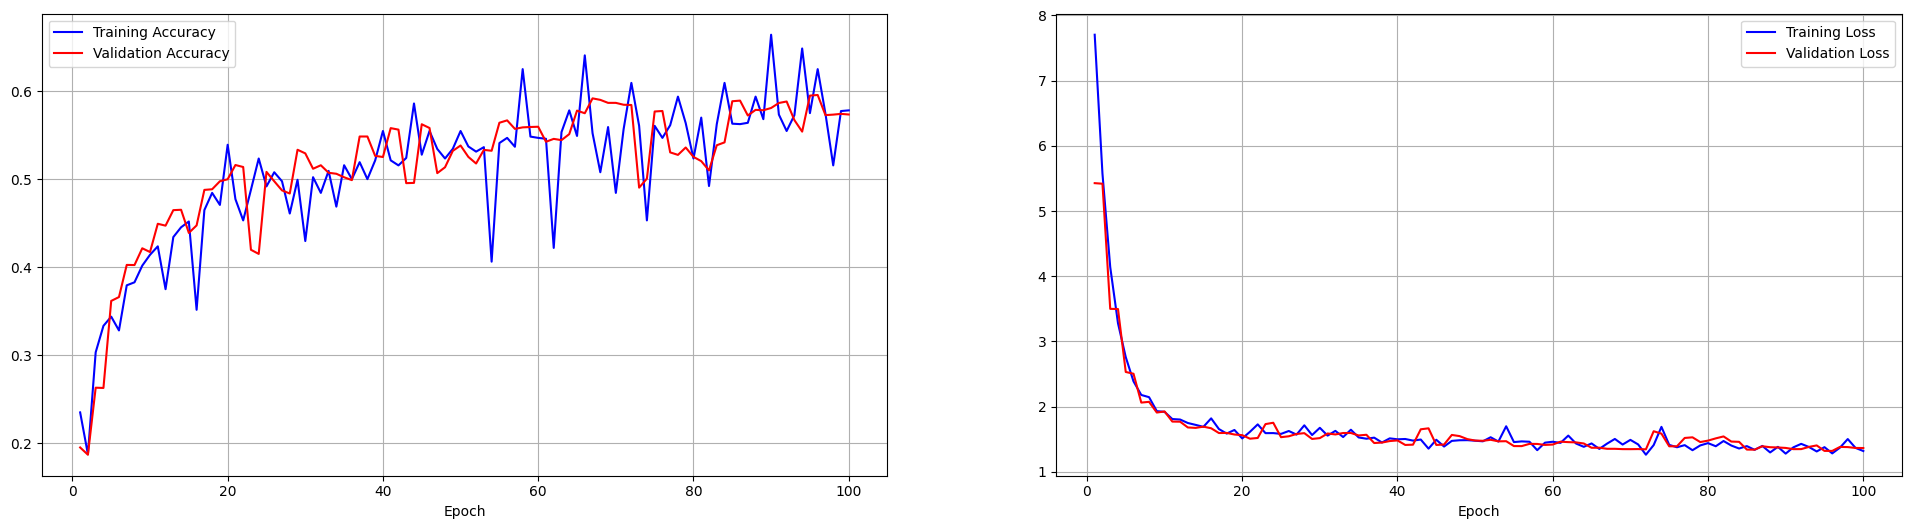

Best Validation Accuracy Score 0.59560, is for epoch 96


In [9]:
plot_results(history)
best_epoch =get_best_epcoh(history)

# Task 5 - Final Evaluation : Predicting the new image

##1. Load the saved model

In [13]:
from tensorflow.keras.models import load_model

# Load the saved model weights
model = load_model('model_weights.keras')

##2. Preprocess the new image

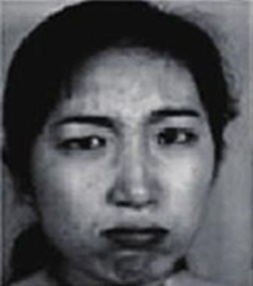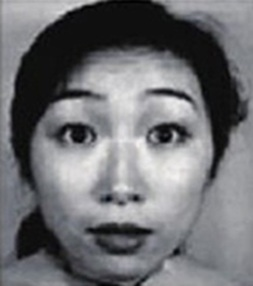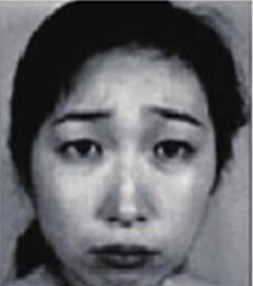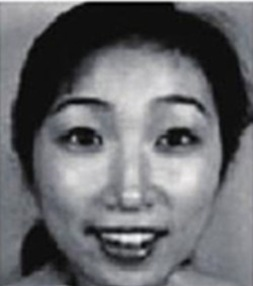

In [26]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Load and preprocess the new image
image_path = '/content/sample_data/Happy1.jpg'  # Replace with the actual path
img = load_img(image_path, target_size=(56, 56), color_mode="grayscale")
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Rescale pixel values

##3. Make the Prediction:

In [27]:
# Make the prediction
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Define class labels (replace with your actual labels)
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Get the predicted class label
predicted_class_label = class_labels[predicted_class_index]

# Print the prediction
print(f"Predicted Emotion: {predicted_class_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Emotion: Happy
